In [74]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.metrics import Precision, Recall , AUC
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import shutil
import random

In [75]:
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 64
EPOCHS = 35
class_names = ['Normal', 'diseases']
class_sizes = {'Normal': 10192, 'diseases': 11941}
VALID_EXTENSIONS = ('.jpg', '.jpeg', '.png')

In [76]:
ORIGINAL_DATASET_DIR = "/kaggle/input/binarydataset/data"
BASE_DIR = "/kaggle/working/dataset_split"

TRAIN_DIR = os.path.join(BASE_DIR, "train")
VAL_DIR = os.path.join(BASE_DIR, "validation")
TEST_DIR = os.path.join(BASE_DIR, "test")

In [77]:
def split_dataset():
    if os.path.exists(BASE_DIR):
        try:
            shutil.rmtree(BASE_DIR)
            print(f"Répertoire {BASE_DIR} supprimé avec succès.")
        except OSError as e:
            print(f"Erreur lors de la suppression de {BASE_DIR} : {e}")
            if e.errno != errno.ENOENT:
                raise
    else:
        print(f"Répertoire {BASE_DIR} n'existait pas, création en cours.")

    os.makedirs(BASE_DIR, exist_ok=True)

    for category in class_names:
        category_path = os.path.join(ORIGINAL_DATASET_DIR, category)
        images = [f for f in os.listdir(category_path) if f.lower().endswith(VALID_EXTENSIONS)]
        random.shuffle(images)

        total = len(images)
        train_split = int(0.7 * total)
        val_split = int(0.9 * total)

        splits = {
            "train": images[:train_split],
            "validation": images[train_split:val_split],
            "test": images[val_split:]
        }

        for split_name, split_images in splits.items():
            split_path = os.path.join(BASE_DIR, split_name, category)
            os.makedirs(split_path, exist_ok=True)

            for img_name in split_images:
                src = os.path.join(category_path, img_name)
                dst = os.path.join(split_path, img_name)
                shutil.copy(src, dst)

        print(f"Classe {category} : Train={len(splits['train'])}, Val={len(splits['validation'])}, Test={len(splits['test'])}")

    print("✅ Dataset split complete!")
    

In [78]:
#split_dataset()

In [79]:
def load_data():
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TRAIN_DIR,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode = 'grayscale',
        batch_size=BATCH_SIZE,
        label_mode='int',
        seed=42
    )

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        VAL_DIR,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode = 'grayscale',
        batch_size=BATCH_SIZE,
        label_mode='int',
        seed=42
    )

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        TEST_DIR,
        image_size=(IMG_HEIGHT, IMG_WIDTH),
        color_mode = 'grayscale',
        batch_size=BATCH_SIZE,
        label_mode='int',
        seed=42
    )

    # Normalisation des images
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
    test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

    # Optimisation des performances
    train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_ds, val_ds, test_ds

In [80]:
train_ds, val_ds, test_ds = load_data()

Found 15492 files belonging to 2 classes.
Found 4426 files belonging to 2 classes.
Found 2215 files belonging to 2 classes.


In [81]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
    flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

In [82]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 222, 222, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 24, 24, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 12, 12, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 10, 10, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 5, 5, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,699,585 (6.48 MB)

 Trainable params: 1,699,585 (6.48 MB)

 Non-trainable params: 0 (0.00 B)

In [83]:
model.compile(
    optimizer=Adam(learning_rate=0.0015),  
    loss='binary_crossentropy',
    metrics=['accuracy',Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
)

In [84]:
from tensorflow.keras.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  
    patience=3,  
    min_lr=0.00001 
)

checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/binary-best_pulmonary_disease_model.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)


callbacks = [early_stopping, reduce_lr, checkpoint]

In [85]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.5731 - auc: 0.6123 - loss: 0.6600 - precision: 0.5784 - recall: 0.6898
Epoch 1: val_loss improved from inf to 0.41205, saving model to /kaggle/working/binary-best_pulmonary_disease_model.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.5735 - auc: 0.6128 - loss: 0.6597 - precision: 0.5787 - recall: 0.6899 - val_accuracy: 0.8057 - val_auc: 0.9094 - val_loss: 0.4121 - val_precision: 0.7736 - val_recall: 0.9045 - learning_rate: 0.0015
Epoch 2/35
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8398 - auc: 0.9160 - loss: 0.3561 - precision: 0.8729 - recall: 0.8213
Epoch 2: val_loss improved from 0.41205 to 0.29077, saving model to /kaggle/working/binary-best_pulmonary_disease_model.keras
243/243 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.8399 - auc: 0.9160 - loss: 0.3560 - precision: 0.8729 - recall: 0.8214 - val_accuracy: 0.8737 - val_auc: 0.9481 - val_loss: 0.2908 - val_precision: 0.8796 - val_r

In [86]:

test_metrics = model.evaluate(test_ds, verbose=0, return_dict=True)
print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test Precision: {test_metrics['precision']:.4f}")
print(f"Test Recall: {test_metrics['recall']:.4f}")
print(f"Test Loss: {test_metrics['loss']:.4f}")
print(f"Test AUC: {test_metrics['auc']:.4f}")

# F1-score
from sklearn.metrics import f1_score
import numpy as np

y_pred = []
y_test = []
for images, labels in test_ds.unbatch():
    pred = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    y_pred.append(np.round(pred[0][0]))
    y_test.append(labels.numpy())

y_pred = np.array(y_pred, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

test_f1 = f1_score(y_test, y_pred)
print(f"Test F1-Score: {test_f1:.4f}")

Test Accuracy: 0.9300
Test Precision: 0.9569
Test Recall: 0.9113
Test Loss: 0.1871
Test AUC: 0.9780


KeyboardInterrupt: 

In [ ]:

from sklearn.metrics import classification_report

y_pred = []
y_test = []
for images, labels in test_ds.unbatch():
    pred = model.predict(tf.expand_dims(images, axis=0), verbose=0)
    y_pred.append(np.round(pred[0][0]))
    y_test.append(labels.numpy())

y_pred = np.array(y_pred, dtype=np.int32)
y_test = np.array(y_test, dtype=np.int32)

# Rapport de classification
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

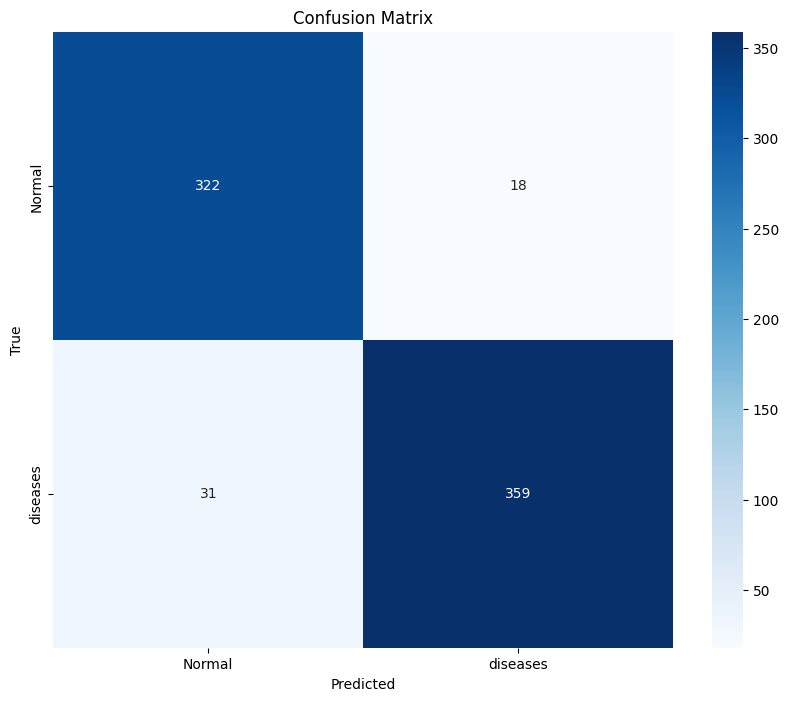

In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('Binaryconfusion_matrix.png')
plt.show()

In [88]:
plt.figure(figsize=(12, 8))

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

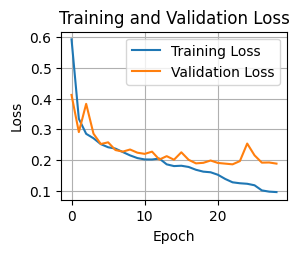

In [89]:
plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('Binaryloss.png')

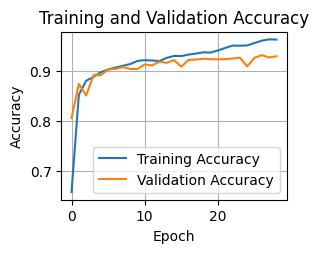

In [90]:
plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('Binaryaccuracy.png')

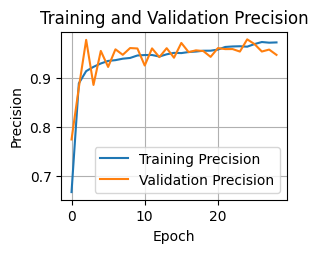

In [91]:
plt.subplot(2, 2, 3)
plt.plot(history.history['precision'], label='Training Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

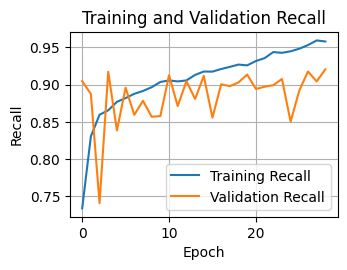

In [92]:
plt.subplot(2, 2, 4)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.tight_layout()

plt.show()

In [93]:
print("\nExemple de prédictions sur l'ensemble de test:")
for i in range(5):
    print(f"Image {i+1}: Prédiction: {class_names[y_pred[i]]}, Vraie classe: {class_names[y_test[i]]}")
</xAngledOutput = True

SyntaxError: invalid syntax (2571942934.py, line 4)